In [1]:
import tensorflow as tf

# Enable TensorFlow device placement logging
tf.debugging.set_log_device_placement(False)

# Check if GPU is available and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd

from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import hamming_loss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, TimeDistributed, Input, Attention
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
import pynvml
import time

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

New Classification
- 0=everything else
- 1=walking
- 2=descending stairs
- 3=ascending stairs


### Train Test Split

In [3]:
demograph = pd.read_csv('participant_demog.csv')
patient_ids = demograph['subj_id'].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)

# Split the data based on patient IDs
train_df =  demograph[demograph['subj_id'].isin(train_ids)]
test_df =  demograph[demograph['subj_id'].isin(test_ids)]

print("Train Patient IDs:", train_ids)
print("Test Patient IDs:", test_ids)

Train Patient IDs: ['id8af5374b' 'id3e3e50c7' 'id650857ca' 'id86237981' 'id34e056c8'
 'id7c20ee7a' 'id5993bf4a' 'idd80ac2b4' 'id5308a7d6' 'id82b9735c'
 'id079c763c' 'ida61e8ddf' 'idbae5a811' 'idecc9265e' 'idb221f542'
 'id1f372081' 'id4ea159a8' 'id8e66893c' 'idf5e3678b' 'id9603e9c3'
 'id687ab496' 'idff99de96']
Test Patient IDs: ['idfc5f05e4' 'id37a54bbf' 'id00b70b13' 'idf1ce9a0f' 'idc91a49d0'
 'id1c7e64ad' 'idf540d82b' 'id1165e00c' 'idc735fc09' 'idabd0c53c']


In [4]:
def sliding_windows(data, window_size, step_size):
    window_list = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size]  # Extract the window
        first_value = window.iloc[0].copy()  # Take the first value of the window
        window_list.append(first_value)
    return window_list

In [5]:
# def load_features(id_df, featured=True):
#     X = []
#     y = []
#     for index, row in id_df.iterrows():
#         id = row['subj_id']
#         print(f'Processing patient {id}')
#         output_dir = 'featured' if featured else 'filtered'
#         pp = pd.read_csv(f'{output_dir}/{id}.csv')
        
#         if not featured:
#             norm_columns = ['lw_norm']#[col for col in pp.columns if col.endswith('_norm')]
#             pp = pp[norm_columns + ['activity']]
#             pp['activity'] = pp['activity'].apply(lambda x: x if x in [1, 2, 3] else 0)
        
#         pp_X = pp.drop(columns=['activity']).values.astype(np.float32)  # Convert to 32-bit floats
#         pp_y = pp['activity'].values.astype(np.int32)  # Convert to 32-bit integers if needed
        
#         X.append(pp_X)
#         y.append(pp_y)
    
#     return np.array(X), np.array(y)

In [6]:
def load_features(id_df, featured=True, window_size=128, step_size=128):
    X = []
    y = []
    
    for index, row in id_df.iterrows():
        id = row['subj_id']
        print(f'Processing patient {id}')
        output_dir = 'featured' if featured else 'filtered'
        pp = pd.read_csv(f'{output_dir}/{id}.csv')
        
        if not featured:
            norm_columns = [col for col in pp.columns if col.endswith('_norm')]
            pp = pp[norm_columns + ['activity']]
            pp['activity'] = pp['activity'].apply(lambda x: x if x in [1, 2, 3] else 0)
            
            # Apply sliding window
            windows = sliding_windows(pp, window_size, step_size)
            pp_X = np.array([window.drop('activity') for window in windows], dtype=np.float32)
            pp_y = np.array([window['activity'] for window in windows], dtype=np.int32)
            X.append(pp_X)
            y.append(pp_y)
            
        else:
            pp_X = pp.drop(columns=['activity']).values.astype(np.float32)  # Convert to 32-bit floats
            pp_y = pp['activity'].values.astype(np.int32)  # Convert to 32-bit integers if needed
            X.append(pp_X)
            y.append(pp_y)
    
    return np.array(X), np.array(y)

In [8]:
featured = False
X_train0, y_train0 = load_features(train_df, featured=featured)
X_test0, y_test0 = load_features(test_df, featured=featured)

Processing patient id5993bf4a
Processing patient idd80ac2b4
Processing patient id82b9735c
Processing patient id8af5374b
Processing patient id650857ca
Processing patient idff99de96
Processing patient id4ea159a8
Processing patient id8e66893c
Processing patient id34e056c8
Processing patient id86237981
Processing patient idf5e3678b
Processing patient id3e3e50c7
Processing patient idecc9265e
Processing patient id687ab496
Processing patient id1f372081
Processing patient id079c763c
Processing patient idbae5a811
Processing patient id7c20ee7a
Processing patient id5308a7d6
Processing patient ida61e8ddf
Processing patient id9603e9c3
Processing patient idb221f542
Processing patient idabd0c53c
Processing patient idc91a49d0
Processing patient id1c7e64ad
Processing patient idc735fc09
Processing patient id37a54bbf
Processing patient idf1ce9a0f
Processing patient id00b70b13
Processing patient id1165e00c
Processing patient idfc5f05e4
Processing patient idf540d82b


In [85]:
# Concatenate data of all patients
X_train_long = np.concatenate(X_train0, axis=0)
y_train_long = np.concatenate(y_train0, axis=0)

X_test_long = np.concatenate(X_test0, axis=0)
y_test_long = np.concatenate(y_test0, axis=0)

print(f'X_train_long shape: {X_train_long.shape}')
print(f'y_train_long shape: {y_train_long.shape}')

X_train_long shape: (16170, 4)
y_train_long shape: (16170,)


In [86]:
# Normalize train and test separately to avoid leaking
scaler = StandardScaler()

X_train_long_scaled = scaler.fit_transform(X_train_long)
X_test_long_scaled = scaler.transform(X_test_long)

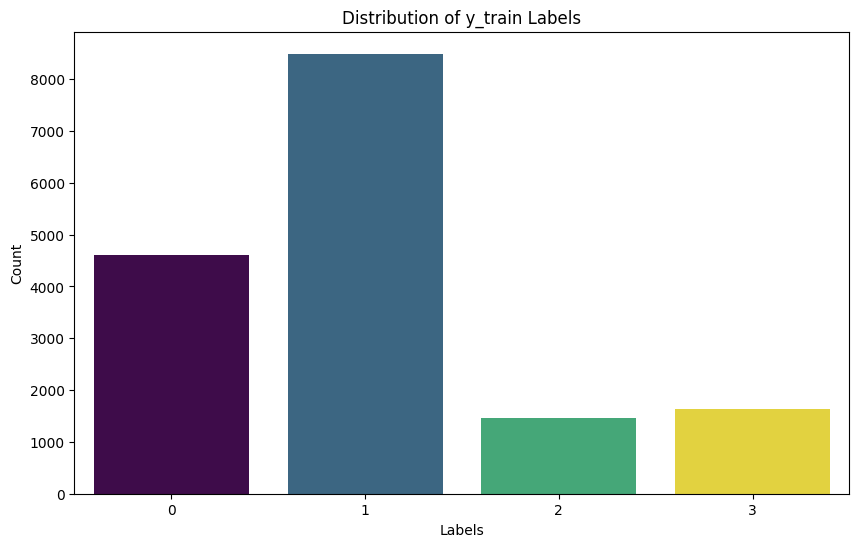

In [87]:
# Count the occurrences of each label
label_counts = pd.Series(y_train_long).value_counts().sort_index()

# Convert label_counts to DataFrame for plotting with hue
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Labels', 'Count']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', hue='Labels', data=label_counts_df, palette='viridis', dodge=False)
plt.title('Distribution of y_train Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

In [88]:
timesteps = X_train0.shape[1]  
# Ensure the total number of data points is divisible by timesteps
num_train_samples = X_train_long_scaled.shape[0] // timesteps
num_test_samples = X_test_long_scaled.shape[0] // timesteps

X_train = X_train_long_scaled[:num_train_samples * timesteps].reshape((num_train_samples, timesteps, -1))
y_train = y_train_long[:num_train_samples * timesteps].reshape((num_train_samples, timesteps, 1))

X_test = X_test_long_scaled[:num_test_samples * timesteps].reshape((num_test_samples, timesteps, -1))
y_test = y_test_long[:num_test_samples * timesteps].reshape((num_test_samples, timesteps, 1))

print(f'X_train: {X_train.shape}') 
print(f'y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}')  
print(f'y_test: {y_test.shape}')  

X_train: (22, 735, 4)
y_train: (22, 735, 1)
X_test: (10, 735, 4)
y_test: (10, 735, 1)


### Split Train Val Data

In [89]:
split_index = int(0.3 * len(X_train))

In [90]:
indices = np.arange(len(X_train))
np.random.seed(898)
np.random.shuffle(indices)
print(indices)

[ 5 12  3 18  1 19 11  9  8 14  2  0  6 21  4 15 16 13 17 20 10  7]


In [91]:
train_indices = indices[split_index:]
val_indices = indices[:split_index]

In [92]:
X_train_split = X_train[train_indices]
y_train_split = y_train[train_indices]
X_val_split = X_train[val_indices]
y_val_split = y_train[val_indices]
print("X_train_split shape:", X_train_split.shape) 
print("y_train_split shape:", y_train_split.shape) 
print("X_val_split shape:", X_val_split.shape)      
print("y_val_split shape:", y_val_split.shape)  

X_train_split shape: (16, 735, 4)
y_train_split shape: (16, 735, 1)
X_val_split shape: (6, 735, 4)
y_val_split shape: (6, 735, 1)


## RNN ONLY

In [64]:
# only RNN
def solo_rnn(units=50, dropout_rate=0.2, recurrent_dropout_rate=0.2):
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=(X_train_split.shape[1], X_train_split.shape[2]), return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
        SimpleRNN(units, activation='tanh', return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
        Dense(4, activation='softmax')  # softmax for classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def grid_search(param_grid, model_fn):
    results = []

    for units in param_grid['units']:
        for dropout_rate in param_grid['dropout_rate']:
            for recurrent_dropout_rate in param_grid['recurrent_dropout_rate']:
                for epochs in param_grid['epochs']:
                    for batch_size in param_grid['batch_size']:
                        print(f"Training with units={units}, dropout_rate={dropout_rate}, recurrent_dropout_rate={recurrent_dropout_rate}, epochs={epochs}, batch_size={batch_size}")

                        # Create and train the model using the provided model function
                        model = model_fn(units, dropout_rate, recurrent_dropout_rate)
                        model.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val_split, y_val_split), verbose=0)
                        val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)

                        print(f"Validation accuracy: {val_accuracy}")
                        
                        results.append({
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'recurrent_dropout_rate': recurrent_dropout_rate,
                            'epochs': epochs,
                            'batch_size': batch_size,
                            'val_accuracy': val_accuracy
                        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='val_accuracy', ascending=False)
    return results_df

In [ ]:
param_grid = {
    'units': [25, 50],
    'dropout_rate': [0, 0.1, 0.2],
    'recurrent_dropout_rate': [0, 0.1, 0.2],
    'epochs': [20],
    'batch_size': [13]
}
res = grid_search(param_grid, create_model)
best_params_rnn = res.iloc[0]

In [ ]:
# # Start checking energy usage
if len(physical_devices)>0:
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    start_energy = pynvml.nvmlDeviceGetPowerUsage(handle)

start_time = time.time()
# Retrain best params with longer epochs 
brnn = solo_rnn(
    units=int(best_params_rnn['units']),
    dropout_rate=float(best_params_rnn['dropout_rate']),
    recurrent_dropout_rate=float(best_params_rnn['recurrent_dropout_rate'])
)

history_rnn = brnn.fit(
    X_train_split,
    y_train_split, 
    epochs=50, 
    batch_size=int(best_params_rnn['batch_size']), 
    validation_data=(X_val_split, y_val_split))


end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

#Energy usage check
if len(physical_devices)>0:
    end_energy = pynvml.nvmlDeviceGetPowerUsage(handle)
    energy_consumed = end_energy - start_energy
    print(f"Energy Consumed: {energy_consumed} mW")
    pynvml.nvmlShutdown()

1/1 [==============================] - 0s 242ms/step - loss: 0.0935 - accuracy: 0.9782
Test loss: 0.09352211654186249, Test accuracy: 0.9782313108444214


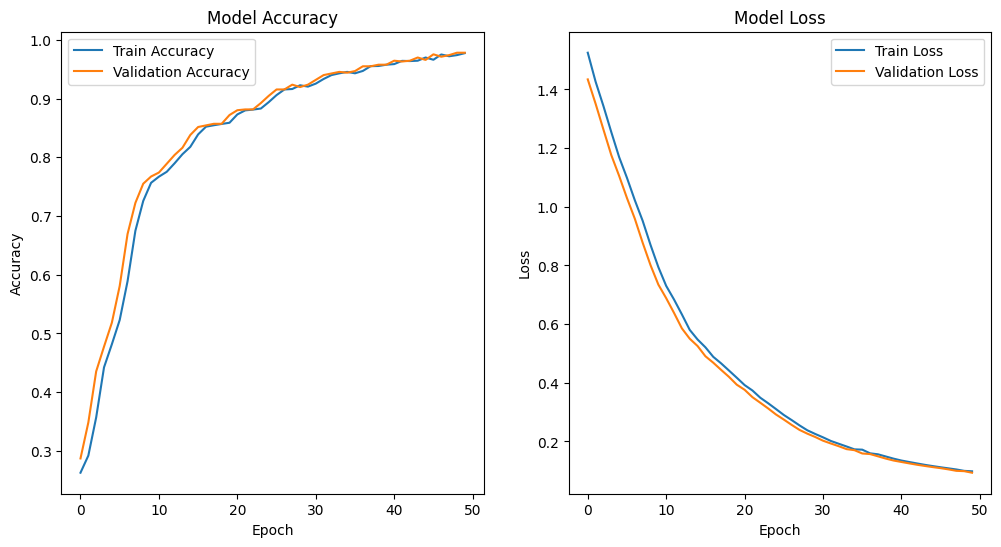

In [68]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 377ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2090
           1       0.99      1.00      0.99      3860
           2       0.97      0.95      0.96       660
           3       0.90      0.99      0.94       740

    accuracy                           0.98      7350
   macro avg       0.96      0.97      0.97      7350
weighted avg       0.98      0.98      0.98      7350



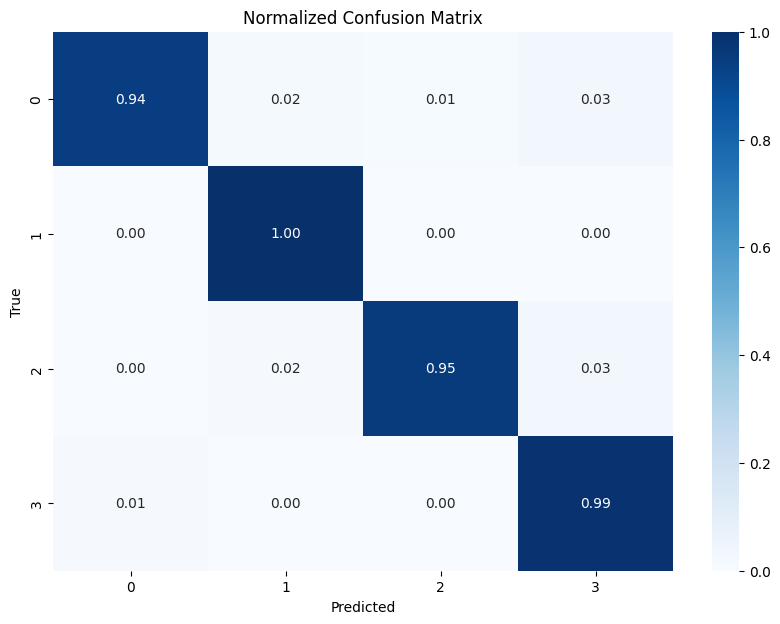

In [69]:
# Make predictions
y_pred1 = brnn.predict(X_test)
y_pred_classes1 = np.argmax(y_pred1, axis=-1)

# Flatten the predictions and true labels
y_pred_flat1 = y_pred_classes1.flatten()
y_true_flat1 = y_test.flatten()

# Generate the classification report
report1 = classification_report(y_true_flat1, y_pred_flat1, zero_division=0, output_dict=True)
print(classification_report(y_true_flat1, y_pred_flat1, zero_division=0))

# Calculate confusion matrix
cm = confusion_matrix(y_true_flat1, y_pred_flat1)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix RNN')
plt.show()

## Evaluation Plot Model 1

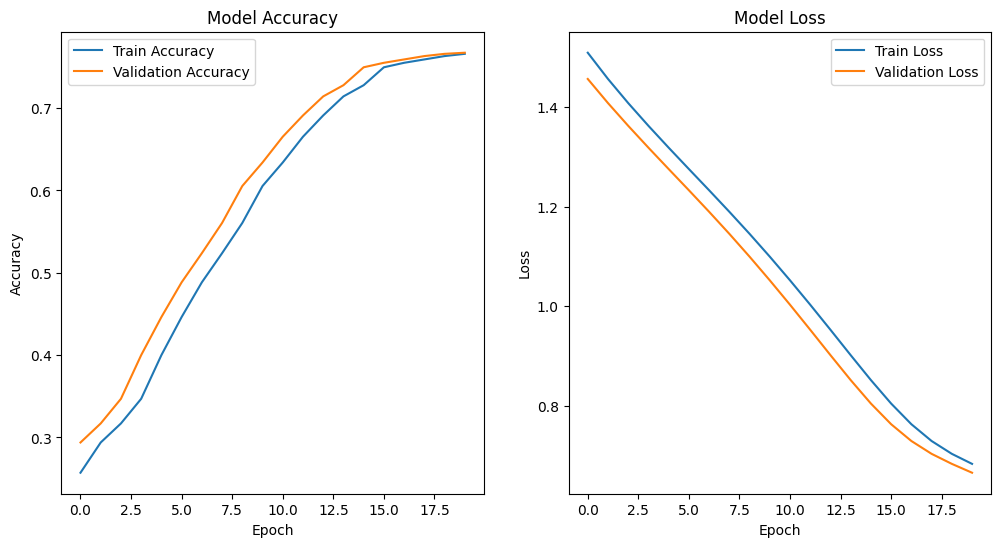

In [62]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 1s 522ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2090
           1       0.75      0.99      0.85      3860
           2       0.78      0.11      0.19       660
           3       0.33      0.01      0.03       740

    accuracy                           0.77      7350
   macro avg       0.67      0.49      0.47      7350
weighted avg       0.73      0.77      0.70      7350



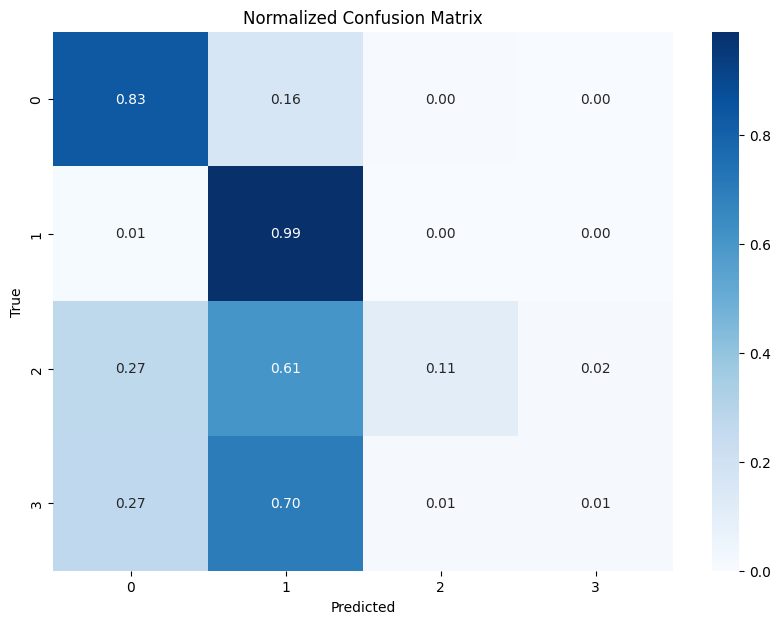

In [63]:
# Make predictions
y_pred1 = model1.predict(X_test)
y_pred_classes1 = np.argmax(y_pred1, axis=-1)

# Flatten the predictions and true labels
y_pred_flat1 = y_pred_classes1.flatten()
y_true_flat1 = y_test.flatten()

# Generate the classification report
report1 = classification_report(y_true_flat1, y_pred_flat1, zero_division=0, output_dict=True)
print(classification_report(y_true_flat1, y_pred_flat1, zero_division=0))

# Calculate confusion matrix
cm = confusion_matrix(y_true_flat1, y_pred_flat1)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

## Train Model 2

In [105]:
# # Start checking energy usage
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
start_energy = pynvml.nvmlDeviceGetPowerUsage(handle)
start_time = time.time()

# Define the model
model2 = Sequential([
    SimpleRNN(50, input_shape=(X_train_split.shape[1], X_train_split.shape[2]), return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    # Dropout(0.2),
    SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    # Dropout(0.5),
    Dense(4, activation='softmax')  # Output layer for 4 classes at each timestep
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the explicit validation set
history2 = model2.fit(X_train_split, y_train_split, epochs=50, validation_data=(X_val_split, y_val_split))

# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1.9009 - accuracy: 0.2545 - val_loss: 1.4284 - val_accuracy: 0.2637
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 1.7701 - accuracy: 0.2888 - val_loss: 1.2365 - val_accuracy: 0.4121
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 1.6255 - accuracy: 0.3370 - val_loss: 1.0737 - val_accuracy: 0.5398
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 1.5423 - accuracy: 0.3597 - val_loss: 0.9398 - val_accuracy: 0.6387
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 1.4418 - accuracy: 0.4044 - val_loss: 0.8345 - val_accuracy: 0.7157
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 1.3427 - accuracy: 0.4354 - val_loss: 0.7566 - val_accuracy: 0.7349
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 1.2386 - accuracy: 0.4822 - val_loss: 0.7032 - val_accuracy: 0.7473
Epoch 8/50
1/1 [=========================

In [110]:
# Time for computing
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")
#Energy usage check
end_energy = pynvml.nvmlDeviceGetPowerUsage(handle)
energy_consumed = end_energy - start_energy
print(f"Energy Consumed: {energy_consumed} mW")
pynvml.nvmlShutdown()

Execution Time: 250.46296668052673 seconds
Energy Consumed: 38 mW


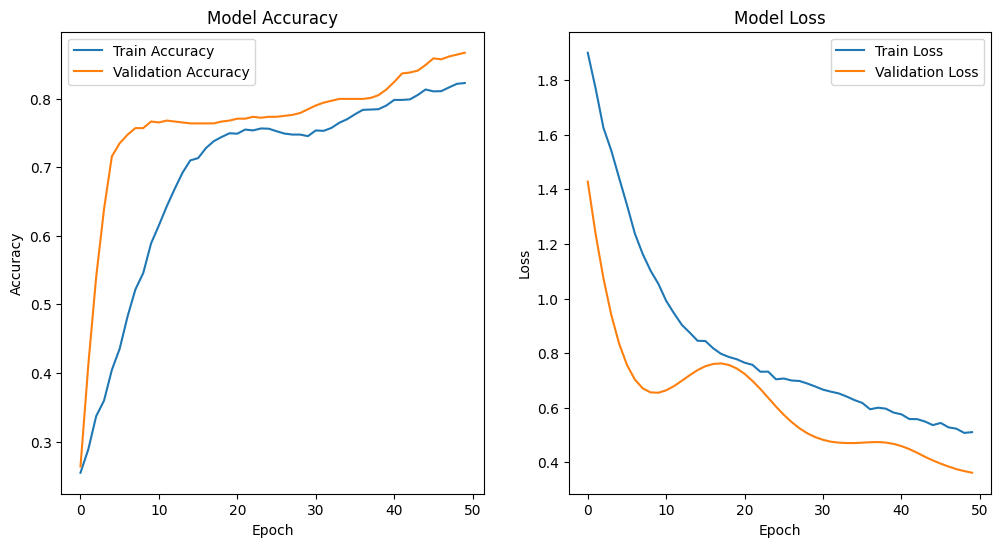

In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [112]:
# Make predictions
y_pred2 = model2.predict(X_test)
y_pred_classes2 = np.argmax(y_pred2, axis=-1)

# Flatten the predictions and true labels
y_pred_flat2 = y_pred_classes2.flatten()
y_true_flat2 = y_test.flatten()

# Generate the classification report
report1 = classification_report(y_true_flat2, y_pred_flat2, zero_division=0, output_dict=True)
print(classification_report(y_true_flat2, y_pred_flat2, zero_division=0))

1/1 [==============================] - 0s 188ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1830
           1       0.84      0.96      0.90      3910
           2       0.78      0.81      0.79       720
           3       0.79      0.18      0.30       820

    accuracy                           0.87      7280
   macro avg       0.85      0.74      0.74      7280
weighted avg       0.86      0.87      0.84      7280



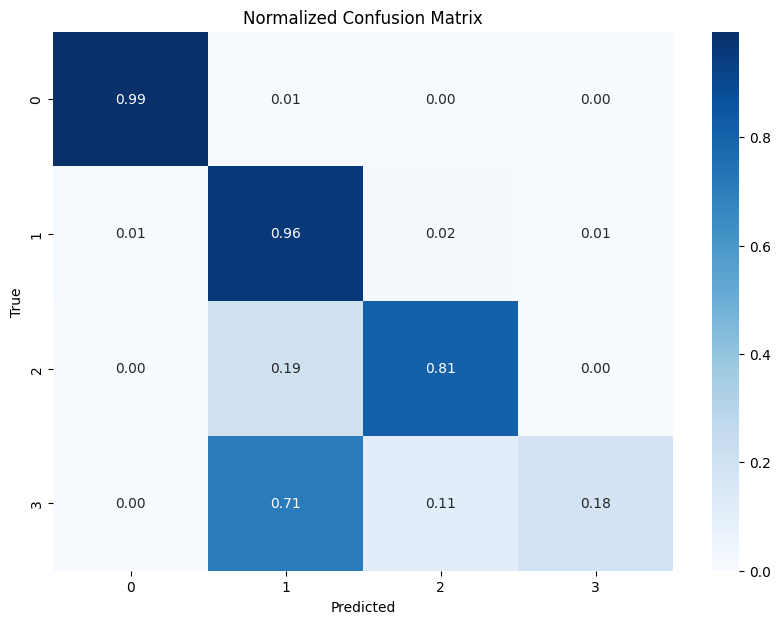

In [113]:
# Calculate confusion matrix
cm = confusion_matrix(y_true_flat2, y_pred_flat2)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

## Train model 3

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.6152 - accuracy: 0.2286 - val_loss: 1.4430 - val_accuracy: 0.3265
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 1.4430 - accuracy: 0.3265 - val_loss: 1.3016 - val_accuracy: 0.4272
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 1.3016 - accuracy: 0.4272 - val_loss: 1.1853 - val_accuracy: 0.4952
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 1.1853 - accuracy: 0.4952 - val_loss: 1.0919 - val_accuracy: 0.6122
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 1.0919 - accuracy: 0.6122 - val_loss: 1.0215 - val_accuracy: 0.6789
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 1.0215 - accuracy: 0.6789 - val_loss: 0.9727 - val_accuracy: 0.7007
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 0.9727 - accuracy: 0.7007 - val_loss: 0.9382 - val_accuracy: 0.7116
Epoch 8/20
1/1 [=========================

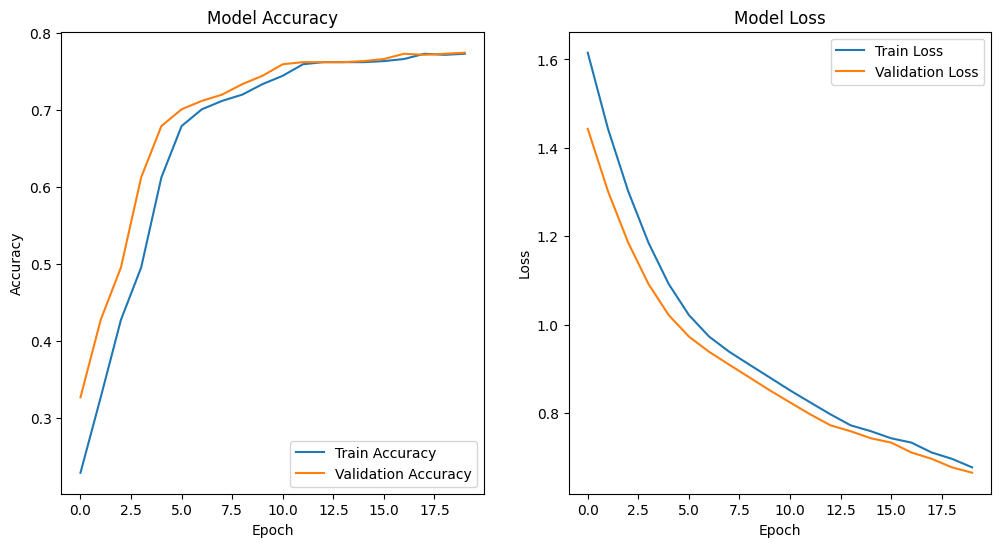

In [95]:
# Define model with 'same' padding in Conv1D to preserve timestep dimension
def CRNN_model(units=50, conv_filters=32, kernel_size=3):
    model = Sequential([
        Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(X_train_split.shape[1], X_train_split.shape[2])),
        SimpleRNN(units, return_sequences=True),
        SimpleRNN(units, return_sequences=True),
        Dense(4, activation='softmax')  # softmax for classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
start_time = time.time()
crnn = CRNN_model(units=50, conv_filters=32, kernel_size=3)
history1 = crnn.fit(X_train_split, y_train_split, epochs=20, batch_size=32, validation_data=(X_val_split, y_val_split))

# Evaluate the model on the test set (ensure you also preprocess X_test and y_test similarly)
loss, accuracy = crnn.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")
print(f"Training time: {time.time() - start_time} seconds")

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [79]:
# Time for computing
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")
#Energy usage check
end_energy = pynvml.nvmlDeviceGetPowerUsage(handle)
energy_consumed = end_energy - start_energy
print(f"Energy Consumed: {energy_consumed} mW")
pynvml.nvmlShutdown()

Execution Time: 809.3690841197968 seconds
Energy Consumed: 286 mW
